In [60]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM
import scipy.stats as stats
import pandas as pd
import os
import pingouin as pg
import warnings
import json
from astropy.stats import rayleightest
from astropy import units as u
warnings.filterwarnings('ignore')

# Day 1: Training

In [ ]:
# data directory, day 1
data_dir = '../data/day1'
# find all csv files in the data directory
all_files = os.listdir(data_dir)
# filter out the csv files
participant_files = [f for f in all_files if f.endswith('.csv')]
# Path to all participant files
participant_files = [data_dir + '/' + f for f in participant_files]


In [ ]:
participant_ids = []
for file_path in participant_files:
    # Extract participant ID
    participant_id = file_path.split('_')[0].split('/')[-1]
    # save the participant ID to the list
    participant_ids.append(participant_id)

In [ ]:
# Add MemoryType and CueCondition columns based on shapeTruth and available cue information
def classify_memory_and_cue(row, wm_values, ltm_values):
    try:
        shape_truth_value = int(row['shapeTruth'])
    except ValueError:
        # If conversion fails, default to a placeholder that won't match WM or LTM values
        shape_truth_value = -1
    # Determine if the item is WM or LTM based on shapeTruth
    memory_type = 'WM' if shape_truth_value in wm_values else 'LTM' if shape_truth_value in ltm_values else 'Unknown'
    cue_condition = 'Neutral' if row['cueLoc'] == 'neutral' else 'Informative' if row['cueLoc'] in ['wm1', 'wm2', 'ltm1', 'ltm2'] else 'Unknown'
    return pd.Series([memory_type, cue_condition], index=['MemoryType', 'CueCondition'])

# Function to calculate error and RT for bins
def calculate_metrics(trials, error_col, rt_col):
    bins_metrics = trials.groupby('bin').agg(
        error=('rawColorDeviation' if error_col == 'rawColorDeviation' else 'rawShapeDeviation', lambda x: np.mean(np.abs(x))),
        rt=(rt_col, 'mean')
    ).reset_index()
    return bins_metrics

In [ ]:
WM_LTM_VALUES = [89, 179, 269, 359]
color_wm = np.array([65, 143, 111]) / 255
color_ltm = np.array([138, 118, 190]) / 255

In [ ]:
# Process each file to analyze learning trials
learning_results = []
sexes = []
ages = []
handednesses = []
# Analyze learning trials
for file_path in participant_files:
    df = pd.read_csv(file_path)
    
    # Extract participant ID
    participant_id = file_path.split('_')[0].split('/')[-1]

    # Learning trials start after this row
    learning_start_idx = df[df['LearnStart.stopped'].notna()].index.max() + 1
    learning_trials = df.iloc[learning_start_idx:].reset_index(drop=True)
    
    # extract demographic information: sex, age, handedness, which is a unique identifier for each participant
    sex = learning_trials['Sex (female/male)'].iloc[0]
    age = learning_trials['Age'].iloc[0]
    handedness = learning_trials['Handedness (left/right)'].iloc[0]

    # Separate color and shape trials
    color_trials = learning_trials[learning_trials['probeType'] == 'color']
    shape_trials = learning_trials[learning_trials['probeType'] == 'shape']
    
    # Bin trials into * bins for each type
    color_trials['bin'] = pd.qcut(color_trials.index, 4, labels=range(1, 5))
    shape_trials['bin'] = pd.qcut(shape_trials.index, 4, labels=range(1, 5))
    
    # Calculate metrics for color and shape trials
    color_metrics = calculate_metrics(color_trials, 'rawColorDeviation', 'LearnColorMouse.time')
    shape_metrics = calculate_metrics(shape_trials, 'rawShapeDeviation', 'LearnShapeMouse.time')
    
    # Add participant ID and trial type to metrics
    color_metrics['participant_id'] = participant_id
    color_metrics['trial_type'] = 'color'
    shape_metrics['participant_id'] = participant_id
    shape_metrics['trial_type'] = 'shape'
    
    # Append results
    learning_results.append(color_metrics)
    learning_results.append(shape_metrics)

    # Append demographic information
    sexes.append(sex)
    ages.append(age)
    handednesses.append(handedness)
    
# Combine all results into a single DataFrame
all_learning_results = pd.concat(learning_results, ignore_index=True)



In [ ]:
# get the summary of demographic information: how many 'female' and 'male' in sexes, average age, and number of people with different handedness
print(sexes)
print(ages)
print(handednesses)

# for sexes, unify the capitalization to lowercase, and count the number of 'female' and 'male'
male_count = 0
female_count = 0
for sex in sexes:
    sex = sex.lower()
    if sex == 'male':
        male_count += 1
    else:
        female_count += 1

# calculate the average age and standard deviation
average_age = np.nanmean(ages)
std_age = np.nanstd(ages)

# count the number of people with different handedness
left_count = 0
right_count = 0
other_count = 0
for handedness in handednesses:
    handedness = handedness.lower()
    handedness = handedness.strip()
    if handedness == 'left' or handedness == 'left-handed':
        left_count += 1
    elif handedness == 'right' or handedness == 'right-handed':
        right_count += 1
    else:
        other_count += 1
        print('Unknown handedness: ', handedness)

print('Number of male: ',male_count)
print('Number of female: ', female_count)
print('Average age: ', average_age)
print('Standard deviation of age: ', std_age)
print('Number of left-handed: ', left_count)
print('Number of right-handed: ', right_count)
print('Number of other handedness: ', other_count)

['Male', 'Male', 'Male', 'female', 'male', 'male', 'female', 'male', 'male', 'male', 'female', 'Female', 'male', 'female', 'male', 'Male', 'male', 'Female', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'female', 'male', 'female', 'Male', 'Male', 'male', 'male', 'male', 'male', 'female', 'male', 'female', 'male', 'male', 'FEMALE', 'Male', 'male', 'male', 'Female', 'male', 'male', 'female', 'female', 'Male', 'female', 'Male', 'male', 'Male', 'male', 'female', 'male', 'Male', 'female', 'female', 'Female', 'male', 'female', 'Male', 'Female', 'female', 'male', 'Male', 'Male', 'female', 'female', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'Male', 'male', 'male', 'Male', 'male', 'male', 'male', 'male', 'female', 'Male', 'male', 'female', 'male', 'male', 'Female', 'male', 'female', 'male', 'male', 'female', 'male', 'male', 'male', 'female', 'Male', 'male', 'male', 'male', 'Female', 'male', 'male', 'female', 'male', 'male', 'male',

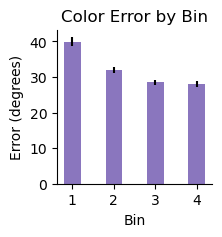

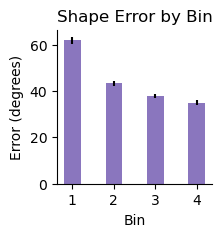

In [ ]:
# Group-level analysis: Calculate the average error and RT for each bin across all participants
group_avg_color_acc = all_learning_results[all_learning_results['trial_type'] == 'color'].groupby('bin')['error'].mean().reset_index()
group_avg_shape_acc = all_learning_results[all_learning_results['trial_type'] == 'shape'].groupby('bin')['error'].mean().reset_index()
group_avg_color_rt = all_learning_results[all_learning_results['trial_type'] == 'color'].groupby('bin')['rt'].mean().reset_index()
group_avg_shape_rt = all_learning_results[all_learning_results['trial_type'] == 'shape'].groupby('bin')['rt'].mean().reset_index()

# Calculate within-participant averages
avg_color_acc = all_learning_results[all_learning_results['trial_type'] == 'color'].groupby(['participant_id', 'bin'])['error'].mean().reset_index()
avg_shape_acc = all_learning_results[all_learning_results['trial_type'] == 'shape'].groupby(['participant_id', 'bin'])['error'].mean().reset_index()
avg_color_rt = all_learning_results[all_learning_results['trial_type'] == 'color'].groupby(['participant_id', 'bin'])['rt'].mean().reset_index()
avg_shape_rt = all_learning_results[all_learning_results['trial_type'] == 'shape'].groupby(['participant_id', 'bin'])['rt'].mean().reset_index()

bins = range(1, 5)
x = np.arange(len(bins))  # the label locations
width = 0.4  # the width of the bars
color_ltm = np.array([138, 118, 190]) / 255

# plot the average error for color trials, with corrected standard error bars
fig, ax = plt.subplots(figsize=(2, 2))
rects1 = ax.bar(x, group_avg_color_acc['error'], width, label='Color', color=color_ltm)
# create pivot table of the color accuracy data, with participant_id as index and bin as columns
color_acc_pivot = avg_color_acc.pivot_table(index='participant_id', columns='bin', values='error')
# Calculate grand mean, subject means, and normalized data
grand_mean = color_acc_pivot.mean().mean()
subject_means = color_acc_pivot.mean(axis=1)
normalized_data = color_acc_pivot.subtract(subject_means, axis=0).add(grand_mean, axis=0)
# Calculate standard error and correction factor
se = normalized_data.sem()
n_subjects = len(color_acc_pivot)
correction_factor = np.sqrt(n_subjects / (n_subjects - 1))
corrected_se_color = se * correction_factor
# add error bars
ax.errorbar(x, group_avg_color_acc['error'], yerr=corrected_se_color, fmt='none', ecolor='black', capsize=0)
ax.set_ylabel('Error (degrees)')
ax.set_xlabel('Bin')
ax.set_xticks(x)
ax.set_xticklabels(bins)
# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Color Error by Bin')
plt.show()

# plot the average error for shape trials, with corrected standard error bars
fig, ax = plt.subplots(figsize=(2, 2))
rects1 = ax.bar(x, group_avg_shape_acc['error'], width, label='Shape', color=color_ltm)
# create pivot table of the shape accuracy data, with participant_id as index and bin as columns
shape_acc_pivot = avg_shape_acc.pivot_table(index='participant_id', columns='bin', values='error')
# Calculate grand mean, subject means, and normalized data
grand_mean = shape_acc_pivot.mean().mean()
subject_means = shape_acc_pivot.mean(axis=1)
normalized_data = shape_acc_pivot.subtract(subject_means, axis=0).add(grand_mean, axis=0)
# Calculate standard error and correction factor
se = normalized_data.sem()
n_subjects = len(shape_acc_pivot)
correction_factor = np.sqrt(n_subjects / (n_subjects - 1))
corrected_se_shape = se * correction_factor
# add error bars
ax.errorbar(x, group_avg_shape_acc['error'], yerr=corrected_se_shape, fmt='none', ecolor='black', capsize=0)
ax.set_ylabel('Error (degrees)')
ax.set_xlabel('Bin')
ax.set_xticks(x)
ax.set_xticklabels(bins)
# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Shape Error by Bin')
plt.show()

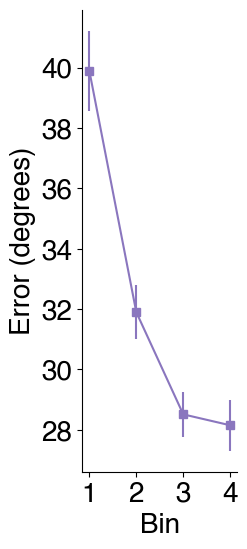

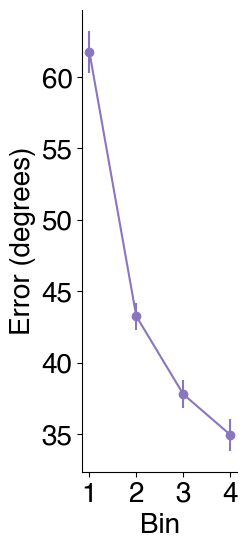

In [ ]:
# instead of bar plots, we can also use line plots to show the trend of the data
fig, ax = plt.subplots(figsize=(2, 6))
ax.plot(group_avg_color_acc['error'], label='Color', color=color_ltm, marker='s', markersize=6)
# add error bars
ax.errorbar(x, group_avg_color_acc['error'], yerr=corrected_se_color, fmt='none', ecolor=color_ltm, capsize=0)
ax.set_ylabel('Error (degrees)')
ax.set_xlabel('Bin')
ax.set_xticks(x)
ax.set_xticklabels(bins)
# ax.set_ylim(0, 45)
# set y ticks to be integers
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_title('Color learning over trials')
# change the axes font to Helvetica and set the font size to 25
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontname('Helvetica')
    item.set_fontsize(20)
plt.show()

fig, ax = plt.subplots(figsize=(2, 6))
ax.plot(group_avg_shape_acc['error'], label='Shape', color=color_ltm, marker='o', markersize=6)
# add error bars
ax.errorbar(x, group_avg_shape_acc['error'], yerr=corrected_se_shape, fmt='none', ecolor=color_ltm, capsize=0)
ax.set_ylabel('Error (degrees)')
ax.set_xlabel('Bin')
ax.set_xticks(x)
ax.set_xticklabels(bins)
# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_title('Shape learning over trials')
# ax.set_ylim(20, 70)
# change the axes font to Helvetica and set the font size to 25
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontname('Helvetica')
    item.set_fontsize(20)
plt.show()

In [ ]:
# perform a repeated measures ANOVA on the color accuracy data, using the statsmodels AnovaRM class

# set up the repeated measures model
color_acc_model = AnovaRM(data=avg_color_acc, depvar='error', subject='participant_id', within=['bin'])
color_acc_fit = color_acc_model.fit()
# print the ANOVA table
print(color_acc_fit)
# do the same using the pingouin package
color_acc_rm = pg.rm_anova(data=avg_color_acc, dv='error', within='bin', subject='participant_id',effsize="np2")

# perform a repeated measures ANOVA on the shape accuracy data, using the statsmodels AnovaRM class

# set up the repeated measures model
shape_acc_model = AnovaRM(data=avg_shape_acc, depvar='error', subject='participant_id', within=['bin'])
shape_acc_fit = shape_acc_model.fit()
# print the ANOVA table
print(shape_acc_fit)
# do the same using the pingouin package
shape_acc_rm = pg.rm_anova(data=avg_shape_acc, dv='error', within='bin', subject='participant_id',effsize="np2")


              Anova
    F Value Num DF  Den DF  Pr > F
----------------------------------
bin 23.4993 3.0000 354.0000 0.0000

              Anova
    F Value Num DF  Den DF  Pr > F
----------------------------------
bin 83.9959 3.0000 354.0000 0.0000



In [ ]:
# Perform one-way repeated-measures ANOVA for color accuracy data
data_melted1 = avg_color_acc
# Contrast weights for bins: [-3, -1, 1, 3]
weights = np.array([-3, -1, 1, 3])
data_melted1['weights'] = data_melted1['bin'].replace({'1': -3, '2': -1, '3': 1, '4': 3})

# Fit the model
model = ols('error ~ weights', data=data_melted1).fit()
anova_table = sm.stats.anova_lm(model, typ=1)

# Calculate partial eta squared for the linear model
ss_effect = anova_table.loc['weights', 'sum_sq']
ss_residual = anova_table.loc['Residual', 'sum_sq']

partial_eta_squared = ss_effect / (ss_effect + ss_residual)

# Add partial eta squared to the ANOVA table
anova_table['Partial Eta Squared'] = [partial_eta_squared, np.nan]

anova_table

,df,sum_sq,mean_sq,F,PR(>F),Partial Eta Squared
weights,3.0,10637.034370,3545.678123,9.015166,0.000008,0.054194
Residual,472.0,185638.294118,393.301471,NaN,NaN,NaN


In [ ]:
# Perform one-way repeated-measures ANOVA for shape accuracy data
data_melted2 = avg_shape_acc
# Contrast weights for bins: [-3, -1, 1, 3]
weights = np.array([-3, -1, 1, 3])
data_melted2['weights'] = data_melted2['bin'].replace({'1': -3, '2': -1, '3': 1, '4': 3})

# Fit the model
model = ols('error ~ weights', data=data_melted2).fit()
anova_table = sm.stats.anova_lm(model, typ=1)

# Calculate partial eta squared for the linear model
ss_effect = anova_table.loc['weights', 'sum_sq']
ss_residual = anova_table.loc['Residual', 'sum_sq']

partial_eta_squared = ss_effect / (ss_effect + ss_residual)

# Add partial eta squared to the ANOVA table
anova_table['Partial Eta Squared'] = [partial_eta_squared, np.nan]

anova_table

,df,sum_sq,mean_sq,F,PR(>F),Partial Eta Squared
weights,3.0,51812.842521,17270.947507,38.469732,2.952887e-22,0.196472
Residual,472.0,211903.926218,448.948996,NaN,NaN,NaN


# Day 2: Memory recall task

In [3]:
def circular_distance(x, y):
    d = y - x
    if isinstance(d, (int, float)):
        if d >= 180:
            return d - 360
        if d < -180:
            return d + 360
        return d
    d[d >= 180] -= 360
    d[d < -180] += 360
    return d

In [4]:
# Add MemoryType and CueCondition columns based on shapeTruth and available cue information
def classify_memory_and_cue(row, wm_values, ltm_values):
    try:
        shape_truth_value = int(row['shapeTruth'])
    except ValueError:
        # If conversion fails, default to a placeholder that won't match WM or LTM values
        shape_truth_value = -1
    # Determine if the item is WM or LTM based on shapeTruth
    memory_type = 'WM' if shape_truth_value in wm_values else 'LTM' if shape_truth_value in ltm_values else 'Unknown'
    cue_condition = 'Neutral' if row['cueLoc'] == 'neutral' else 'Informative' if row['cueLoc'] in ['wm1', 'wm2', 'ltm1', 'ltm2'] else 'Unknown'
    return pd.Series([memory_type, cue_condition], index=['MemoryType', 'CueCondition'])

In [5]:
# data directory
data_dir = '../data/day2'
# find all csv files in the data directory
all_files = os.listdir(data_dir)
# filter out the csv files
participant_files = [f for f in all_files if f.endswith('.csv')]
# Path to all participant files
participant_files = [data_dir + '/' + f for f in participant_files]
# Constants
WM_LTM_VALUES = [89, 179, 269, 359]
color_wm = np.array([65, 143, 111]) / 255
color_ltm = np.array([138, 118, 190]) / 255


In [6]:
participant_ids = []
for file_path in participant_files:
    # Extract participant ID
    participant_id = file_path.split('_')[0].split('/')[-1]
    # save the participant ID to the list
    participant_ids.append(participant_id)

participant_files = [f for f in participant_files if f.split('_')[0].split('/')[-1] in participant_ids]

In [7]:

def process_participant_data(file_path,participant_id):
    data = pd.read_csv(file_path)
    ltm_values = data[['trueMemory1', 'trueMemory2']].dropna().astype(int).values.flatten().tolist()
    wm_values = [value for value in WM_LTM_VALUES if value not in ltm_values]
    test_trial_start_index = data['PracBlockEnd.stopped'].first_valid_index() + 1
    test_trials = data.iloc[test_trial_start_index:]
    test_trials['ParticipantID'] = participant_id  # Add participant identifier
    memory_trials = test_trials[test_trials['taskType'] == 'memory']
    memory_trials['ltm_shapes'] = [ltm_values for _ in range(len(memory_trials))]
    memory_trials['wm_shapes'] = [wm_values for _ in range(len(memory_trials))]
    memory_trials[['MemoryType', 'CueCondition']] = memory_trials.apply(
        lambda row: classify_memory_and_cue(row, wm_values,ltm_values), axis=1)

    return memory_trials[['ParticipantID', 'mouseTime', 'shapeTruth', 'selectedShape', 'deviation', 'rawDeviation', 'MemoryType', 'CueCondition', 'ltm_shapes', 'wm_shapes']]

# Process data for all participants with participant identifiers
# participant_ids = [f"Participant_{i+1}" for i in range(len(participant_files))]
data_list = []
for path,pid in zip(participant_files,participant_ids):
    tmp = process_participant_data(path,pid)
    data_list.append(tmp)

all_participants_data = pd.concat(data_list,ignore_index=True)

# Identify and exclude outlier trials where the rection time is over 3 SD criterion larger or smaller than the mean. Calculate the mean and standard deviation of the reaction time for each participant. 
all_participants_data['mouseTime'] = all_participants_data['mouseTime'].astype(float)
for pid in participant_ids:
    participant_data = all_participants_data[all_participants_data['ParticipantID'] == pid]
    mean_time = participant_data['mouseTime'].mean()
    std_time = participant_data['mouseTime'].std()
    participant_data['outlier'] = (participant_data['mouseTime'] < mean_time - 3 * std_time) | (participant_data['mouseTime'] > mean_time + 3 * std_time)
    all_participants_data.loc[all_participants_data['ParticipantID'] == pid, 'outlier'] = participant_data['outlier']
# Caluclate the rate of outlier trials for each participant
outlier_rates = all_participants_data.groupby('ParticipantID')['outlier'].mean()
# Calculate the average rate and standard deviation of outlier trials across all participants
mean_outlier_rate = outlier_rates.mean()
std_outlier_rate = outlier_rates.std()
print(f'Mean outlier rate: {mean_outlier_rate:.3f} ± {std_outlier_rate:.3f}')

# Calculate the overall rate of outlier trials
outlier_trials = all_participants_data[all_participants_data['outlier'] == True]
outlier_trials_count = outlier_trials.shape[0]
outlier_trials_rate = outlier_trials_count / all_participants_data.shape[0]
print(f'Rate of outlier trials: {outlier_trials_rate:.3f}')

memory_task_data = all_participants_data

# Exclude outlier trials
all_participants_data = all_participants_data[all_participants_data['outlier'] == False]

Mean outlier rate: 0.011 ± 0.009
Rate of outlier trials: 0.012


In [ ]:

# Group data by MemoryType and CueCondition for RT analysis
grouped_data = all_participants_data.groupby(['MemoryType', 'CueCondition'])['mouseTime'].mean().reset_index()

# Calculate within-participant averages for RT, considering both MemoryType and CueCondition
within_participant_averages = all_participants_data.groupby(['ParticipantID', 'MemoryType', 'CueCondition'])['mouseTime'].mean().reset_index()

# Calculate group-level averages for RT, considering both MemoryType and CueCondition
group_level_averages = within_participant_averages.groupby(['MemoryType', 'CueCondition'])['mouseTime'].mean().reset_index()




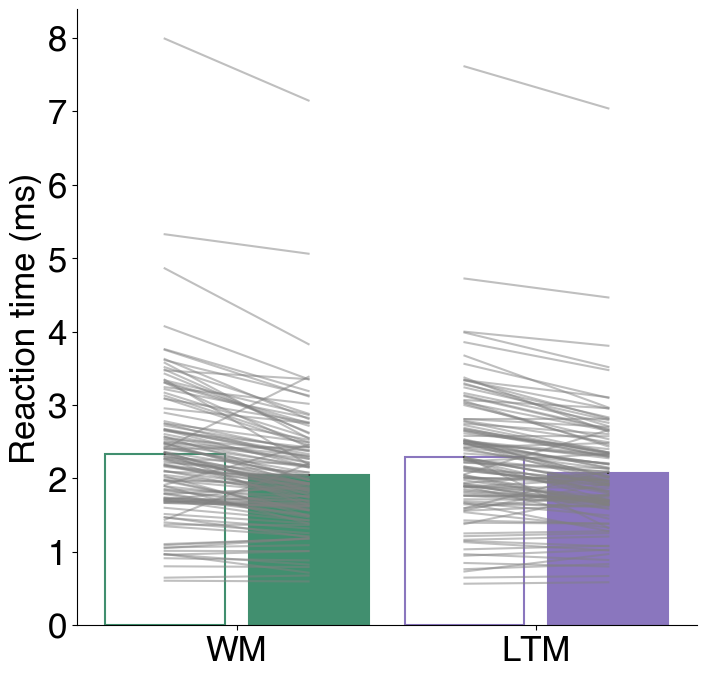

In [9]:
conditions = ('WM', 'LTM')
x = np.arange(len(conditions))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 8))
informative_means = group_level_averages[group_level_averages['CueCondition'] == 'Informative']['mouseTime']
# reorder the informative_means so that WM is plotted first
informative_means = informative_means.to_list()[::-1]
neutral_means = group_level_averages[group_level_averages['CueCondition'] == 'Neutral']['mouseTime']
# reorder the neutral_means so that WM is plotted first
neutral_means = neutral_means.to_list()[::-1]
rects1 = ax.bar(x + width*0.6, informative_means, width, label='Informative', color=[color_wm, color_ltm], edgecolor= [color_wm, color_ltm], linewidth=1.5, linestyle='-')
rects2 = ax.bar(x - width*0.6, neutral_means, width, label='Neutral', color= 'none', edgecolor=[color_wm, color_ltm], linewidth=1.5, linestyle='-')

# choose from within_participant_averages the accuracy data for each condition(combine memory type and cue condition)
rt_data = within_participant_averages.pivot_table(index='ParticipantID', columns=['MemoryType', 'CueCondition'], values='mouseTime')
# Calculate grand mean, subject means, and normalized data
grand_mean = rt_data.mean().mean()
subject_means = rt_data.mean(axis=1)
normalized_data = rt_data.subtract(subject_means, axis=0).add(grand_mean, axis=0)

# Calculate standard error and correction factor
se = normalized_data.sem()
n_subjects = len(rt_data)
correction_factor = np.sqrt(n_subjects / (n_subjects - 1))
corrected_se = se * correction_factor
corrected_se = corrected_se.to_list()
informative_se = corrected_se[:2]
# reorder the informative_se so that WM is plotted first
informative_se = informative_se[::-1]
neutral_se = corrected_se[2:]
# reorder the neutral_se so that WM is plotted first
neutral_se = neutral_se[::-1]
# Add error bars
ax.errorbar(x + width*0.6, informative_means, yerr=informative_se, fmt='none', ecolor='black', capsize=0)
ax.errorbar(x - width*0.6, neutral_means, yerr=neutral_se, fmt='none', ecolor='black', capsize=0)

# add individual participant lines
for memory_type in ['WM', 'LTM']:
    participant_data = within_participant_averages[within_participant_averages['MemoryType'] == memory_type]
    informative_data = participant_data[participant_data['CueCondition'] == 'Informative']
    neutral_data = participant_data[participant_data['CueCondition'] == 'Neutral']
    for participant in participant_ids:
        informative_deviation = informative_data[informative_data['ParticipantID'] == participant]['mouseTime'].values
        neutral_deviation = neutral_data[neutral_data['ParticipantID'] == participant]['mouseTime'].values
        # adjust the x position of the lines
        x_position = 0 if memory_type == 'WM' else 1
        plt.plot([x_position - width*0.6, x_position + width*0.6], [neutral_deviation,informative_deviation], color='grey', alpha=0.5)
        
ax.set_ylabel('Reaction time (ms)')
ax.set_xticks(x)
ax.set_xticklabels(conditions)
# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# set y axis limits
ax.set_ylim(0, None)
# ax.set_title('Reproduction RTs by Memory Type and Cue Condition')

# change the axes font to Helvetica and set the font size to 25
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontname('Helvetica')
    item.set_fontsize(25)
    
plt.show()

In [10]:
#perform two-way repeated measures ANOVA: (within-subject factor 1: MemoryType, within-subject factor 2: CueCondition)

# set up the repeated measures model
memory_model = AnovaRM(data=within_participant_averages, depvar='mouseTime', subject='ParticipantID', within=['MemoryType', 'CueCondition'])
memory_fit = memory_model.fit()
# print the ANOVA table
# print(memory_fit)
# do the same thing using pingouin
pg.rm_anova(data=within_participant_averages, dv='mouseTime', within=['MemoryType', 'CueCondition'], subject='ParticipantID',effsize="np2")


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,MemoryType,0.014319,1,118,0.014319,0.271328,6.034183e-01,6.034183e-01,0.002294,1.0
1,CueCondition,7.517035,1,118,7.517035,113.286674,5.922767e-19,5.922767e-19,0.489811,1.0
2,MemoryType * CueCondition,0.169759,1,118,0.169759,12.643272,5.434381e-04,5.434381e-04,0.096777,1.0


In [11]:

# perform a paired-samples (informative vs neutral) t-test for WM and LTM separately
# WM
# Informative cue
informative_wm = within_participant_averages[(within_participant_averages['MemoryType'] == 'WM') & (within_participant_averages['CueCondition'] == 'Informative')]['mouseTime']
# Neutral cue
neutral_wm = within_participant_averages[(within_participant_averages['MemoryType'] == 'WM') & (within_participant_averages['CueCondition'] == 'Neutral')]['mouseTime']
# Perform the t-test
pg.ttest(informative_wm, neutral_wm, paired=True)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-10.080192,118,two-sided,1.293784e-17,"[-0.35, -0.23]",0.318225,4.346e+14,0.930973


In [12]:

t, p = stats.ttest_rel(informative_wm, neutral_wm)
print('t = %f, p = %f' % (t, p))


t = -10.080192, p = 0.000000


In [13]:

# LTM
# Informative cue
informative_ltm = within_participant_averages[(within_participant_averages['MemoryType'] == 'LTM') & (within_participant_averages['CueCondition'] == 'Informative')]['mouseTime']
# Neutral cue
neutral_ltm = within_participant_averages[(within_participant_averages['MemoryType'] == 'LTM') & (within_participant_averages['CueCondition'] == 'Neutral')]['mouseTime']
# Perform the t-test
pg.ttest(informative_ltm, neutral_ltm, paired=True)



,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-9.380751,118,two-sided,5.862839e-16,"[-0.26, -0.17]",0.25268,1.054e+13,0.780522


In [14]:
pg.ttest(neutral_wm, neutral_ltm, paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.923721,118,two-sided,0.056798,"[-0.0, 0.1]",0.05174,0.604,0.086608


In [15]:
# subtract informative from neutral for both WM and LTM, and do a paired t-test
# Subtract neutral from informative (need to transform neutral and informative from Series to numpy array)
diff_wm = informative_wm.values - neutral_wm.values
diff_ltm = informative_ltm.values - neutral_ltm.values
# Perform the t-test
pg.ttest(diff_wm, diff_ltm, paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-3.555738,118,two-sided,0.000543,"[-0.12, -0.03]",0.267438,36.215,0.824751


In [16]:
all_participants_data['MemoryType'].value_counts()

MemoryType
LTM    14025
WM     13989
Name: count, dtype: int64

In [ ]:
# Group data by MemoryType and CueCondition for deviation analysis
# change the type of deviation to float
all_participants_data['deviation'] = all_participants_data['deviation'].astype(float)
grouped_data = all_participants_data.groupby(['MemoryType', 'CueCondition'])['deviation'].mean().reset_index()

# Calculate within-participant averages, considering both MemoryType and CueCondition
acc_sub_avg = all_participants_data.groupby(['ParticipantID', 'MemoryType', 'CueCondition'])['deviation'].mean().reset_index()

# Calculate group-level averages, considering both MemoryType and CueCondition
group_level_averages = acc_sub_avg.groupby(['MemoryType', 'CueCondition'])['deviation'].mean().reset_index()



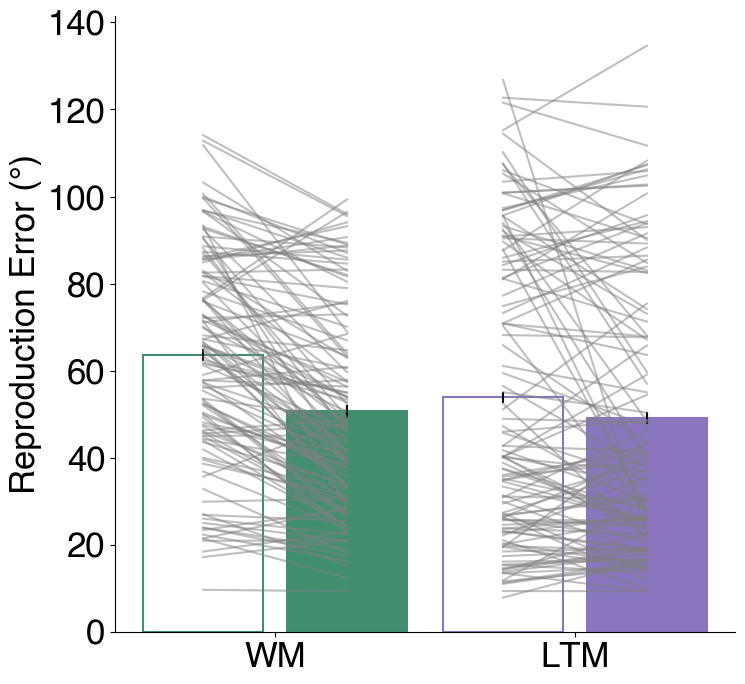

In [18]:
conditions = ('WM', 'LTM')
x = np.arange(len(conditions))  # the label locations
width = 0.4  # the width of the bars

# reorder group_level_averages based on 'MemoryType' so that WM is plotted first

fig, ax = plt.subplots(figsize=(8, 8))
informative_means = group_level_averages[group_level_averages['CueCondition'] == 'Informative']['deviation']
# reorder the informative_means so that WM is plotted first
informative_means = informative_means.to_list()[::-1]
neutral_means = group_level_averages[group_level_averages['CueCondition'] == 'Neutral']['deviation']
# reorder the neutral_means so that WM is plotted first
neutral_means = neutral_means.to_list()[::-1]
rects1 = ax.bar(x + width*0.6, informative_means, width, label='Informative', color=[color_wm, color_ltm], edgecolor=[color_wm, color_ltm], linewidth=1.5, linestyle='-')
rects2 = ax.bar(x - width*0.6, neutral_means, width, label='Neutral', color= 'none', edgecolor=[color_wm, color_ltm], linewidth=1.5, linestyle='-')

# choose from within_participant_averages the accuracy data for each condition(combine memory type and cue condition)
acc_data = acc_sub_avg.pivot_table(index='ParticipantID', columns=['MemoryType', 'CueCondition'], values='deviation')
# Calculate grand mean, subject means, and normalized data
grand_mean = acc_data.mean().mean()
subject_means = acc_data.mean(axis=1)
normalized_data = acc_data.subtract(subject_means, axis=0).add(grand_mean, axis=0)

# Calculate standard error and correction factor
se = normalized_data.sem()
n_subjects = len(acc_data)
correction_factor = np.sqrt(n_subjects / (n_subjects - 1))
corrected_se = se * correction_factor
corrected_se = corrected_se.to_list()
informative_se = corrected_se[:2]
# reorder the informative_se so that WM is plotted first
informative_se = informative_se[::-1]
neutral_se = corrected_se[2:]
# reorder the neutral_se so that WM is plotted first
neutral_se = neutral_se[::-1]

# Add error bars
ax.errorbar(x + width*0.6, informative_means, yerr=informative_se, fmt='none', ecolor='black', capsize=0)
ax.errorbar(x - width*0.6, neutral_means, yerr=neutral_se, fmt='none', ecolor='black', capsize=0)

# add individual participant lines
for memory_type in ['WM', 'LTM']:
    participant_data = acc_sub_avg[acc_sub_avg['MemoryType'] == memory_type]
    informative_data = participant_data[participant_data['CueCondition'] == 'Informative']
    neutral_data = participant_data[participant_data['CueCondition'] == 'Neutral']
    for participant in participant_ids:
        informative_deviation = informative_data[informative_data['ParticipantID'] == participant]['deviation'].values
        neutral_deviation = neutral_data[neutral_data['ParticipantID'] == participant]['deviation'].values
        # adjust the x position of the lines
        x_position = 0 if memory_type == 'WM' else 1
        plt.plot([x_position - width*0.6, x_position + width*0.6], [neutral_deviation,informative_deviation], color='grey', alpha=0.5)

        
ax.set_ylabel('Reproduction Error (°)')
ax.set_xticks(x)
ax.set_xticklabels(conditions)
# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# set y axis limits
# ax.set_title('Reproduction Errors by Memory Type and Cue Condition')

# change the axes font to Helvetica and set the font size to 25
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontname('Helvetica')
    item.set_fontsize(25)
plt.show()

In [19]:
ltm_data = acc_sub_avg[acc_sub_avg['MemoryType'] == 'LTM']
# calculate the average deviation for each participant, collapsed across cue condition
ltm_data = ltm_data.groupby('ParticipantID')['deviation'].mean().reset_index()
# save the deviation data to a csv file
ltm_data.to_csv('ltm_deviation.csv', index=False)
# get a list of particpants whose deviation is smaller than 60
ltm_good_pids = ltm_data[ltm_data['deviation'] < 60]['ParticipantID'].tolist()
# do a median split and get two lists of participants
ltm_data['deviation_median'] = ltm_data['deviation'].median()
ltm_low_pids = ltm_data[ltm_data['deviation'] < ltm_data['deviation_median']]['ParticipantID'].tolist()
ltm_high_pids = ltm_data[ltm_data['deviation'] >= ltm_data['deviation_median']]['ParticipantID'].tolist()
# add informative and neutral columns from acc_data
ltm_data['informative'] = acc_data['LTM']['Informative'].values
ltm_data['neutral'] = acc_data['LTM']['Neutral'].values
ltm_data['reproduction_benefit'] = ltm_data['neutral'] - ltm_data['informative']
ltm_data['rt_informative'] = rt_data['LTM']['Informative'].values
ltm_data['rt_neutral'] = rt_data['LTM']['Neutral'].values
ltm_data['reproduction_rt_benefit'] = ltm_data['rt_neutral'] - ltm_data['rt_informative']

wm_data = acc_sub_avg[acc_sub_avg['MemoryType'] == 'WM']
# calculate the average deviation for each participant, collapsed across cue condition, 
wm_data = wm_data.groupby('ParticipantID')['deviation'].mean().reset_index()
# add informative and neutral columns from acc_data
wm_data['informative'] = acc_data['WM']['Informative'].values
wm_data['neutral'] = acc_data['WM']['Neutral'].values
wm_data['reproduction_benefit'] = wm_data['neutral'] - wm_data['informative']
wm_data['rt_informative'] = rt_data['WM']['Informative'].values
wm_data['rt_neutral'] = rt_data['WM']['Neutral'].values
wm_data['reproduction_rt_benefit'] = wm_data['rt_neutral'] - wm_data['rt_informative']


In [20]:
acc_data['LTM_cue_effect'] = acc_data['LTM']['Informative'] - acc_data['LTM']['Neutral']
acc_data['WM_cue_effect'] = acc_data['WM']['Informative'] - acc_data['WM']['Neutral']
# create a new dataframe for retrocue effect on deviation
cue_effect = pd.DataFrame()
cue_effect['ParticipantID'] = acc_data.index
cue_effect['LTM_cue_effect'] = acc_data['LTM_cue_effect'].values
cue_effect['WM_cue_effect'] = acc_data['WM_cue_effect'].values
cue_effect = pd.melt(cue_effect, id_vars='ParticipantID', value_vars=['LTM_cue_effect', 'WM_cue_effect'], var_name='variable', value_name='CueEffect')
cue_effect['MemoryType'] = cue_effect['variable'].str.extract(r'(LTM|WM)_', expand=True)
cue_effect.drop(columns='variable', inplace=True)



In [21]:
#perform two-way repeated measures ANOVA: (within-subject factor 1: MemoryType, within-subject factor 2: CueCondition)

# set up the repeated measures model
memory_model = AnovaRM(data=acc_sub_avg, depvar='deviation', subject='ParticipantID', within=['MemoryType', 'CueCondition'])
memory_fit = memory_model.fit()
# print the ANOVA table
# print(memory_fit)
# do the same thing using pingouin
pg.rm_anova(data=acc_sub_avg, dv='deviation', within=['MemoryType', 'CueCondition'], subject='ParticipantID',effsize="np2")


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,MemoryType,3798.741754,1,118,3798.741754,6.947296,9.522727e-03,9.522727e-03,0.055602,1.0
1,CueCondition,9184.797910,1,118,9184.797910,55.518992,1.677694e-11,1.677694e-11,0.319959,1.0
2,MemoryType * CueCondition,1969.050527,1,118,1969.050527,15.215687,1.599149e-04,1.599149e-04,0.114218,1.0


In [22]:

# perform a paired-samples (informative vs neutral) t-test for WM and LTM separately
# WM
# Informative cue
informative_wm = acc_sub_avg[(acc_sub_avg['MemoryType'] == 'WM') & (acc_sub_avg['CueCondition'] == 'Informative')]['deviation']
# Neutral cue
neutral_wm = acc_sub_avg[(acc_sub_avg['MemoryType'] == 'WM') & (acc_sub_avg['CueCondition'] == 'Neutral')]['deviation']
# Perform the t-test
pg.ttest(informative_wm, neutral_wm, paired=True)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-9.581485,118,two-sided,1.967621e-16,"[-15.51, -10.2]",0.540174,3.054e+13,0.999949


In [23]:

# LTM
# Informative cue
informative_ltm = acc_sub_avg[(acc_sub_avg['MemoryType'] == 'LTM') & (acc_sub_avg['CueCondition'] == 'Informative')]['deviation']
# Neutral cue
neutral_ltm = acc_sub_avg[(acc_sub_avg['MemoryType'] == 'LTM') & (acc_sub_avg['CueCondition'] == 'Neutral')]['deviation']
# Perform the t-test
pg.ttest(informative_ltm, neutral_ltm, paired=True)



,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.655619,118,two-sided,0.00901,"[-8.24, -1.2]",0.143495,2.897,0.342096


In [24]:
# Perform the t-test
pg.ttest(neutral_wm, neutral_ltm, paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.806967,118,two-sided,0.000225,"[4.66, 14.77]",0.330992,81.597,0.947512


In [25]:
# subtract informative from neutral for both WM and LTM, and do a paired t-test
# Subtract neutral from informative (need to transform neutral and informative from Series to numpy array)
diff_wm = informative_wm.values - neutral_wm.values
diff_ltm = informative_ltm.values - neutral_ltm.values
# Perform the t-test
pg.ttest(diff_wm, diff_ltm, paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-3.900729,118,two-sided,0.00016,"[-12.27, -4.01]",0.473793,111.737,0.999227


# Day 2: Perceptual task

In [26]:
# Define the ParticipantID-integer mappings, read from mapping.json
import json
with open('../exp3_particpant_mapping.json', 'r') as f:
    participant_id_mapping = json.load(f)


In [27]:
# Define CueCondition
def determine_cue_condition(row, wm_locs, ltm_locs):
    cue_loc = row['cueLoc']
    if cue_loc == 'neutral':
        return 'neutral'
    else:
        # Convert cueLoc to number
        locs_mapping = {'wm1': wm_locs[0], 'wm2': wm_locs[1], 'ltm1': ltm_locs[0], 'ltm2': ltm_locs[1]}
        cue_loc_num = locs_mapping.get(cue_loc, None)
        
        # Determine matching or nonmatching
        if cue_loc_num == row['perceptLoc']:
            return 'matching'
        else:
            return 'nonmatching'

In [28]:

# Initialize a list to store percept_trials dataframes for all participants
all_percept_trials = []
for file_path,n in zip(participant_files,range(len(participant_files))):
    # Extract ParticipantID from the filename
    filename = Path(file_path).stem
    participant_id = filename.split('_')[0]
    participant_group = participant_id_mapping[participant_id]['group']
    
    # Determine WM and LTM locs based on the ParticipantID integer
    if participant_group == 'A':  # Even number
        ltm_locs = [1, 4]
        wm_locs = [2, 3]
    else:  # Odd number
        ltm_locs = [2, 3]
        wm_locs = [1, 4]
    
    # Load data
    data = pd.read_csv(file_path)
    test_trial_start_index = data['PracBlockEnd.stopped'].first_valid_index() + 1
    test_trials = data.iloc[test_trial_start_index:]
    # Filter for 'percept' taskType
    percept_trials = test_trials[test_trials['taskType'] == 'percept'].copy()
    # Define MemoryType based on perceptLoc
    percept_trials['MemoryType'] = percept_trials['perceptLoc'].apply(
        lambda x: 'WM' if x in wm_locs else 'LTM'
    )
    
    percept_trials['CueCondition'] = percept_trials.apply(lambda row: determine_cue_condition(row, wm_locs, ltm_locs), axis=1)
    percept_trials['ParticipantID'] = participant_ids[n]
    # Select and rename required variables
    percept_trials = percept_trials.rename(columns={'PerceptProbeKey.rt': 'RT', 'PerceptProbeKey.corr': 'Accuracy'})
    percept_trials = percept_trials[['ParticipantID', 'RT', 'Accuracy', 'MemoryType', 'CueCondition']]
    
    # Append to the list
    all_percept_trials.append(percept_trials)

# Concatenate all participant data
all_percept_trials_df = pd.concat(all_percept_trials, ignore_index=True)
# convert accuracy to percentage
all_percept_trials_df['Accuracy'] = all_percept_trials_df['Accuracy'] * 100
# Identify and exclude outlier trials where the rection time is over 3 SD criterion larger or smaller than the mean. Calculate the mean and standard deviation of the reaction time for each participant.
all_percept_trials_df['RT'] = all_percept_trials_df['RT'].astype(float)
for pid in participant_ids:
    participant_data = all_percept_trials_df[all_percept_trials_df['ParticipantID'] == pid]
    mean_time = participant_data['RT'].mean()
    std_time = participant_data['RT'].std()
    participant_data['outlier'] = (participant_data['RT'] < mean_time - 3 * std_time) | (participant_data['RT'] > mean_time + 3 * std_time)
    all_percept_trials_df.loc[all_percept_trials_df['ParticipantID'] == pid, 'outlier'] = participant_data['outlier']
# Caluclate the rate of outlier trials for each participant
outlier_rates = all_percept_trials_df.groupby('ParticipantID')['outlier'].mean()
# Calculate the average rate and standard deviation of outlier trials across all participants
mean_outlier_rate = outlier_rates.mean()
std_outlier_rate = outlier_rates.std()
print(f'Mean outlier rate: {mean_outlier_rate:.3f} ± {std_outlier_rate:.3f}')

# Calculate the overall rate of outlier trials
outlier_trials = all_percept_trials_df[all_percept_trials_df['outlier'] == True]
outlier_trials_count = outlier_trials.shape[0]
outlier_trials_rate = outlier_trials_count / all_percept_trials_df.shape[0]
print(f'Rate of outlier trials: {outlier_trials_rate:.3f}')

percept_task_data = all_percept_trials_df

# Exclude outlier trials
all_percept_trials_df = all_percept_trials_df[all_percept_trials_df['outlier'] == False]


Mean outlier rate: 0.016 ± 0.008
Rate of outlier trials: 0.016


In [29]:
all_percept_trials_df['MemoryType'].value_counts()

MemoryType
LTM    13967
WM     13928
Name: count, dtype: int64

In [ ]:
# Group data by MemoryType and CueCondition for accuracy analysis
grouped_data = all_percept_trials_df.groupby(['MemoryType', 'CueCondition'])['Accuracy'].mean().reset_index()
# Calculate within-participant averages, considering both MemoryType and CueCondition
within_participant_averages = all_percept_trials_df.groupby(['ParticipantID', 'MemoryType', 'CueCondition'])['Accuracy'].mean().reset_index()

# ****************************************************************************
# filter to include only participants with deviation less than 60
# ltm_participants = ltm_data['ParticipantID'][ltm_data['deviation'] < 30]
# within_participant_averages = within_participant_averages[within_participant_averages['ParticipantID'].isin(ltm_participants)]
# ****************************************************************************

# Calculate group-level averages, considering both MemoryType and CueCondition
group_level_averages = within_participant_averages.groupby(['MemoryType', 'CueCondition'])['Accuracy'].mean().reset_index()


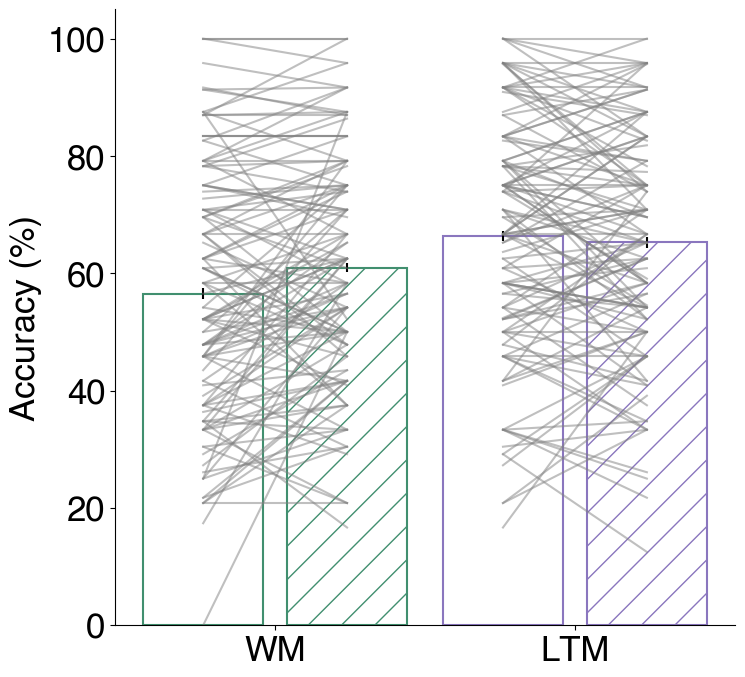

In [49]:
conditions = ('WM', 'LTM')
x = np.arange(len(conditions))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 8))
matching_means = group_level_averages[group_level_averages['CueCondition'] == 'matching']['Accuracy']
# reorder the matching_means so that WM is plotted first
matching_means = matching_means.to_list()[::-1]
neutral_means = group_level_averages[group_level_averages['CueCondition'] == 'neutral']['Accuracy']
# reorder the neutral_means so that WM is plotted first
neutral_means = neutral_means.to_list()[::-1]
rects1 = ax.bar(x + width*0.6, matching_means, width, label='Matching', color='none', edgecolor=[color_wm, color_ltm], linewidth=1.5, linestyle='-',hatch="/")
rects2 = ax.bar(x - width*0.6, neutral_means, width, label='Neutral', color= 'none', edgecolor=[color_wm, color_ltm], linewidth=1.5, linestyle='-')

# choose from within_participant_averages the accuracy data for each condition(combine memory type and cue condition)
acc_data = within_participant_averages.pivot_table(index='ParticipantID', columns=['MemoryType', 'CueCondition'], values='Accuracy')
# remove the nonmatching condition
acc_data = acc_data.drop(columns='nonmatching', level=1)
# Calculate grand mean, subject means, and normalized data
grand_mean = acc_data.mean().mean()
subject_means = acc_data.mean(axis=1)
normalized_data = acc_data.subtract(subject_means, axis=0).add(grand_mean, axis=0)

# Calculate standard error and correction factor
se = normalized_data.sem()
n_subjects = len(acc_data)
correction_factor = np.sqrt(n_subjects / (n_subjects - 1))
corrected_se = se * correction_factor
corrected_se = corrected_se.to_list()
matching_se = corrected_se[:2]
# reorder the matching_se so that WM is plotted first
matching_se = matching_se[::-1]
neutral_se = corrected_se[2:]
# reorder the neutral_se so that WM is plotted first
neutral_se = neutral_se[::-1]

# Add error bars
ax.errorbar(x + width*0.6, matching_means, yerr=matching_se, fmt='none', ecolor='black', capsize=0)
ax.errorbar(x - width*0.6, neutral_means, yerr=neutral_se, fmt='none', ecolor='black', capsize=0)


# add individual participant lines
for memory_type in ['WM', 'LTM']:
    participant_data = within_participant_averages[within_participant_averages['MemoryType'] == memory_type]
    matching_data = participant_data[participant_data['CueCondition'] == 'matching']
    neutral_data = participant_data[participant_data['CueCondition'] == 'neutral']
    for participant in participant_ids:
        matching_accuracy = matching_data[matching_data['ParticipantID'] == participant]['Accuracy'].values
        neutral_accuracy = neutral_data[neutral_data['ParticipantID'] == participant]['Accuracy'].values
        # adjust the x position of the lines
        x_position = 0 if memory_type == 'WM' else 1
        plt.plot([x_position - width*0.6, x_position + width*0.6], [neutral_accuracy,matching_accuracy], color='grey', alpha=0.5)

ax.set_ylabel('Accuracy (%)')
ax.set_xticks(x)
ax.set_xticklabels(conditions)
# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# set y axis limits
ax.set_ylim(0, None)
# ax.set_title('Perceptual Task Accuracy')

# change the axes font to Helvetica and set the font size to 25
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontname('Helvetica')
    item.set_fontsize(25)

plt.show()



# Nonmatching vs. neutral

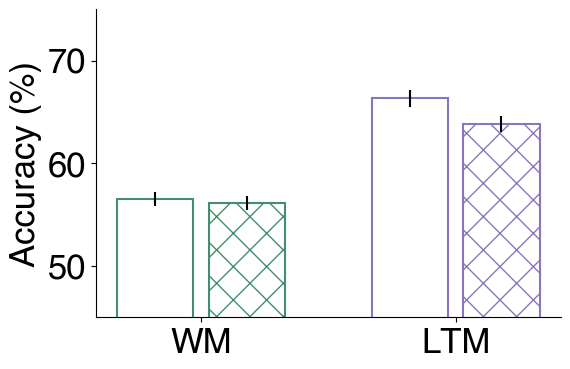

In [64]:
conditions = ('WM', 'LTM')
x = np.arange(len(conditions))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(6, 4))
nonmatching_means = group_level_averages[group_level_averages['CueCondition'] == 'nonmatching']['Accuracy']
# reorder the matching_means so that WM is plotted first
nonmatching_means = nonmatching_means.to_list()[::-1]
neutral_means = group_level_averages[group_level_averages['CueCondition'] == 'neutral']['Accuracy']
# reorder the neutral_means so that WM is plotted first
neutral_means = neutral_means.to_list()[::-1]
rects1 = ax.bar(x + width*0.6, nonmatching_means, width, label='Matching', color='none', edgecolor=[color_wm, color_ltm], linewidth=1.5, linestyle='-',hatch="x")
rects2 = ax.bar(x - width*0.6, neutral_means, width, label='Neutral', color= 'none', edgecolor=[color_wm, color_ltm], linewidth=1.5, linestyle='-')

# choose from within_participant_averages the accuracy data for each condition(combine memory type and cue condition)
acc_data = within_participant_averages.pivot_table(index='ParticipantID', columns=['MemoryType', 'CueCondition'], values='Accuracy')
# remove the matching condition
acc_data = acc_data.drop(columns='matching', level=1)
# Calculate grand mean, subject means, and normalized data
grand_mean = acc_data.mean().mean()
subject_means = acc_data.mean(axis=1)
normalized_data = acc_data.subtract(subject_means, axis=0).add(grand_mean, axis=0)

# Calculate standard error and correction factor
se = normalized_data.sem()
n_subjects = len(acc_data)
correction_factor = np.sqrt(n_subjects / (n_subjects - 1))
corrected_se = se * correction_factor
corrected_se = corrected_se.to_list()
nonmatching_se = corrected_se[:2]
# reorder the matching_se so that WM is plotted first
nonmatching_se = nonmatching_se[::-1]
neutral_se = corrected_se[2:]
# reorder the neutral_se so that WM is plotted first
neutral_se = neutral_se[::-1]

# Add error bars
ax.errorbar(x + width*0.6, nonmatching_means, yerr=nonmatching_se, fmt='none', ecolor='black', capsize=0)
ax.errorbar(x - width*0.6, neutral_means, yerr=neutral_se, fmt='none', ecolor='black', capsize=0)


# add individual participant lines
# for memory_type in ['WM', 'LTM']:
#     participant_data = within_participant_averages[within_participant_averages['MemoryType'] == memory_type]
#     nonmatching_data = participant_data[participant_data['CueCondition'] == 'nonmatching']
#     neutral_data = participant_data[participant_data['CueCondition'] == 'neutral']
#     for participant in participant_ids:
#         nonmatching_accuracy = nonmatching_data[nonmatching_data['ParticipantID'] == participant]['Accuracy'].values
#         neutral_accuracy = neutral_data[neutral_data['ParticipantID'] == participant]['Accuracy'].values
#         # adjust the x position of the lines
#         x_position = 0 if memory_type == 'WM' else 1
#         plt.plot([x_position - width*0.6, x_position + width*0.6], [neutral_accuracy,nonmatching_accuracy], color='grey', alpha=0.5)

ax.set_ylabel('Accuracy (%)')
ax.set_xticks(x)
ax.set_yticks([50,60,70])
ax.set_xticklabels(conditions)
# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# set y axis limits
ax.set_ylim(45, 75)
# ax.set_title('Perceptual Task Accuracy')

# change the axes font to Helvetica and set the font size to 25
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontname('Helvetica')
    item.set_fontsize(25)

plt.show()



In [33]:
#perform two-way repeated measures ANOVA: (within-subject factor 1: MemoryType, within-subject factor 2: CueCondition)

# set up the repeated measures model
memory_model = AnovaRM(data=within_participant_averages[within_participant_averages['CueCondition'] != 'nonmatching'], depvar='Accuracy', subject='ParticipantID', within=['MemoryType', 'CueCondition'])
memory_fit = memory_model.fit()
# print the ANOVA table
print(memory_fit)
# do the same thing using pingouin
pg.rm_anova(data=within_participant_averages[within_participant_averages['CueCondition'] != 'nonmatching'], dv='Accuracy', within=['MemoryType', 'CueCondition'], subject='ParticipantID', effsize="np2")

                        Anova
                        F Value Num DF  Den DF  Pr > F
------------------------------------------------------
MemoryType              32.2130 1.0000 118.0000 0.0000
CueCondition             3.4729 1.0000 118.0000 0.0649
MemoryType:CueCondition 10.3281 1.0000 118.0000 0.0017



,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,MemoryType,5979.385420,1,118,5979.385420,32.212977,1.005380e-07,1.005380e-07,0.214449,1.0
1,CueCondition,341.174981,1,118,341.174981,3.472917,6.486710e-02,6.486710e-02,0.028590,1.0
2,MemoryType * CueCondition,877.494567,1,118,877.494567,10.328093,1.689764e-03,1.689764e-03,0.080482,1.0


In [34]:
#perform two-way repeated measures ANOVA: (within-subject factor 1: MemoryType, within-subject factor 2: CueCondition)

# set up the repeated measures model
memory_model = AnovaRM(data=within_participant_averages[within_participant_averages['CueCondition'] != 'matching'], depvar='Accuracy', subject='ParticipantID', within=['MemoryType', 'CueCondition'])
memory_fit = memory_model.fit()
# print the ANOVA table
print(memory_fit)
# do the same thing using pingouin
pg.rm_anova(data=within_participant_averages[within_participant_averages['CueCondition'] != 'matching'], dv='Accuracy', within=['MemoryType', 'CueCondition'], subject='ParticipantID', effsize="np2")

                        Anova
                        F Value Num DF  Den DF  Pr > F
------------------------------------------------------
MemoryType              54.6109 1.0000 118.0000 0.0000
CueCondition             4.3707 1.0000 118.0000 0.0387
MemoryType:CueCondition  3.0149 1.0000 118.0000 0.0851



,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,MemoryType,9091.132009,1,118,9091.132009,54.610866,2.298745e-11,2.298745e-11,0.316381,1.0
1,CueCondition,239.772218,1,118,239.772218,4.370668,3.870936e-02,3.870936e-02,0.035717,1.0
2,MemoryType * CueCondition,134.596955,1,118,134.596955,3.014858,8.511465e-02,8.511465e-02,0.024913,1.0


In [35]:
# perform a paired-samples (matching vs neutral) t-test for WM and LTM separately
# WM
# Matching cue
matching_wm = within_participant_averages[(within_participant_averages['MemoryType'] == 'WM') & (within_participant_averages['CueCondition'] == 'matching')]['Accuracy']
# Neutral cue
neutral_wm = within_participant_averages[(within_participant_averages['MemoryType'] == 'WM') & (within_participant_averages['CueCondition'] == 'neutral')]['Accuracy']
# Perform the t-test
pg.ttest(matching_wm, neutral_wm, paired=True)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.308055,118,two-sided,0.001246,"[1.77, 7.05]",0.213807,16.994,0.638106


In [36]:

# LTM
# Matching cue
matching_ltm = within_participant_averages[(within_participant_averages['MemoryType'] == 'LTM') & (within_participant_averages['CueCondition'] == 'matching')]['Accuracy']
# Neutral cue
neutral_ltm = within_participant_averages[(within_participant_averages['MemoryType'] == 'LTM') & (within_participant_averages['CueCondition'] == 'neutral')]['Accuracy']
# Perform the t-test
pg.ttest(matching_ltm, neutral_ltm, paired=True)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.895605,118,two-sided,0.372287,"[-3.28, 1.24]",0.051942,0.15,0.0869


In [37]:
# subtract matching from neutral for both WM and LTM, and do a paired t-test
# Subtract neutral from matching (need to transform neutral and matching from Series to numpy array)
diff_wm = matching_wm.values - neutral_wm.values
diff_ltm = matching_ltm.values - neutral_ltm.values
# Perform the t-test
pg.ttest(diff_wm, diff_ltm, paired=True)

# # get the mean and standard error of diff_wm and diff_ltm
# mean_diff_wm = np.mean(diff_wm)
# se_diff_wm = np.std(diff_wm)/np.sqrt(len(diff_wm))
# mean_diff_ltm = np.mean(diff_ltm)
# se_diff_ltm = np.std(diff_ltm)/np.sqrt(len(diff_ltm))
# print(f'Mean difference for WM: {mean_diff_wm:.3f} ± {se_diff_wm:.3f}')
# print(f'Mean difference for LTM: {mean_diff_ltm:.3f} ± {se_diff_ltm:.3f}')

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.213735,118,two-sided,0.00169,"[2.08, 8.78]",0.40125,12.893,0.991374


In [39]:
# ltm_data['percpet_acc_matching'] = acc_data['LTM']['matching'].values
# wm_data['percpet_acc_matching'] = acc_data['WM']['matching'].values

In [ ]:
# Group data by MemoryType and CueCondition
grouped_data = all_percept_trials_df.groupby(['MemoryType', 'CueCondition'])['RT'].mean().reset_index()
# Calculate within-participant averages for RT, considering both MemoryType and CueCondition
within_participant_averages = all_percept_trials_df.groupby(['ParticipantID', 'MemoryType', 'CueCondition'])['RT'].mean().reset_index()
# Calculate group-level averages for RT, considering both MemoryType and CueCondition
group_level_averages = within_participant_averages.groupby(['MemoryType', 'CueCondition'])['RT'].mean().reset_index()


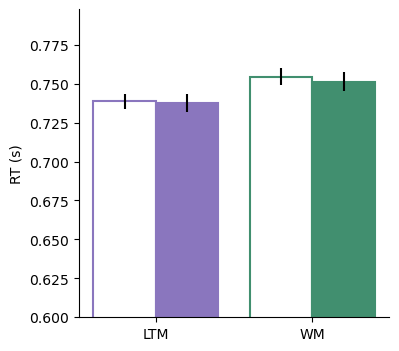

In [41]:
conditions = ('LTM', 'WM')
x = np.arange(len(conditions))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(4, 4))
matching_means = group_level_averages[group_level_averages['CueCondition'] == 'matching']['RT']
neutral_means = group_level_averages[group_level_averages['CueCondition'] == 'neutral']['RT']
rects1 = ax.bar(x + width/2, matching_means, width, label='Matching', color=[color_ltm, color_wm], edgecolor=[color_ltm, color_wm], linewidth=1.5, linestyle='-')
rects2 = ax.bar(x - width/2, neutral_means, width, label='Neutral', color= 'none', edgecolor=[color_ltm, color_wm], linewidth=1.5, linestyle='-')

# choose from within_participant_averages the accuracy data for each condition(combine memory type and cue condition)
rt_data = within_participant_averages.pivot_table(index='ParticipantID', columns=['MemoryType', 'CueCondition'], values='RT')
# remove the nonmatching condition
rt_data = rt_data.drop(columns='nonmatching', level=1)
# Calculate grand mean, subject means, and normalized data
grand_mean = rt_data.mean().mean()
subject_means = rt_data.mean(axis=1)
normalized_data = rt_data.subtract(subject_means, axis=0).add(grand_mean, axis=0)

# Calculate standard error and correction factor
se = normalized_data.sem()
n_subjects = len(rt_data)
correction_factor = np.sqrt(n_subjects / (n_subjects - 1))
corrected_se = se * correction_factor

# Add error bars
ax.errorbar(x + width/2, matching_means, yerr=corrected_se[:2], fmt='none', ecolor='black', capsize=0)
ax.errorbar(x - width/2, neutral_means, yerr=corrected_se[2:], fmt='none', ecolor='black', capsize=0)

ax.set_ylabel('RT (s)')
ax.set_xticks(x)
ax.set_xticklabels(conditions)
# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# set y axis limits
ax.set_ylim(0.6, None)
# ax.set_title('Perceptual Task Accuracy')

plt.show()



In [42]:
#perform two-way repeated measures ANOVA: (within-subject factor 1: MemoryType, within-subject factor 2: CueCondition)

# set up the repeated measures model
memory_model = AnovaRM(data=within_participant_averages[within_participant_averages['CueCondition'] != 'nonmatching'], depvar='RT', subject='ParticipantID', within=['MemoryType', 'CueCondition'])
memory_fit = memory_model.fit()
# print the ANOVA table
print(memory_fit)
# do the same thing using pingouin
pg.rm_anova(data=within_participant_averages[within_participant_averages['CueCondition'] != 'nonmatching'], dv='RT', within=['MemoryType', 'CueCondition'], subject='ParticipantID', effsize="np2")

                        Anova
                        F Value Num DF  Den DF  Pr > F
------------------------------------------------------
MemoryType               6.4192 1.0000 118.0000 0.0126
CueCondition             0.0999 1.0000 118.0000 0.7525
MemoryType:CueCondition  0.0247 1.0000 118.0000 0.8753



,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,MemoryType,0.024905,1,118,0.024905,6.419171,0.012601,0.012601,0.051593,1.0
1,CueCondition,0.000527,1,118,0.000527,0.099936,0.752465,0.752465,0.000846,1.0
2,MemoryType * CueCondition,0.000131,1,118,0.000131,0.024717,0.875343,0.875343,0.000209,1.0


#Nonmatching

In [43]:
#perform two-way repeated measures ANOVA: (within-subject factor 1: MemoryType, within-subject factor 2: CueCondition)

# set up the repeated measures model
memory_model = AnovaRM(data=within_participant_averages[within_participant_averages['CueCondition'] != 'matching'], depvar='RT', subject='ParticipantID', within=['MemoryType', 'CueCondition'])
memory_fit = memory_model.fit()
# print the ANOVA table
print(memory_fit)
# do the same thing using pingouin
pg.rm_anova(data=within_participant_averages[within_participant_averages['CueCondition'] != 'matching'], dv='RT', within=['MemoryType', 'CueCondition'], subject='ParticipantID', effsize="np2")

                        Anova
                        F Value Num DF  Den DF  Pr > F
------------------------------------------------------
MemoryType               3.9957 1.0000 118.0000 0.0479
CueCondition             9.4197 1.0000 118.0000 0.0027
MemoryType:CueCondition  0.2913 1.0000 118.0000 0.5904



,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,MemoryType,0.019907,1,118,0.019907,3.995743,0.047914,0.047914,0.032753,1.0
1,CueCondition,0.031757,1,118,0.031757,9.419723,0.002664,0.002664,0.073927,1.0
2,MemoryType * CueCondition,0.000794,1,118,0.000794,0.291254,0.590435,0.590435,0.002462,1.0


In [44]:
# perform a paired-samples (matching vs neutral) t-test for WM and LTM separately
# WM
# Matching cue
matching_wm = within_participant_averages[(within_participant_averages['MemoryType'] == 'WM') & (within_participant_averages['CueCondition'] == 'matching')]['RT']
# Neutral cue
neutral_wm = within_participant_averages[(within_participant_averages['MemoryType'] == 'WM') & (within_participant_averages['CueCondition'] == 'neutral')]['RT']
# Perform the t-test
pg.ttest(matching_wm, neutral_wm, paired=True)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.372478,118,two-sided,0.710205,"[-0.02, 0.01]",0.010976,0.109,0.051617


In [45]:

# LTM
# Matching cue
matching_ltm = within_participant_averages[(within_participant_averages['MemoryType'] == 'LTM') & (within_participant_averages['CueCondition'] == 'matching')]['RT']
# Neutral cue
neutral_ltm = within_participant_averages[(within_participant_averages['MemoryType'] == 'LTM') & (within_participant_averages['CueCondition'] == 'neutral')]['RT']
# Perform the t-test
pg.ttest(matching_ltm, neutral_ltm, paired=True)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.102262,118,two-sided,0.918722,"[-0.02, 0.02]",0.003665,0.102,0.05018
